In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [81]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib

from PIL import Image
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Embedding, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.nn import softmax
from sklearn.metrics import accuracy_score, classification_report

In [16]:
data = pd.read_csv('/content/drive/MyDrive/DeepLearning/Colab/Customer_sentiment_Classifications/Customer_sentiment.csv')

data[['Text', 'Sentiment', 'Source', 'Date/Time', 'User ID', 'Location', 'Confidence Score']] = data['Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score'].str.split(',', expand = True)

data = data.drop('Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score', axis=1)
data.head()

,Text,Sentiment,Source,Date/Time,User ID,Location,Confidence Score
0,"""I love this product!""",Positive,Twitter,2023-06-15 09:23:14,@user123,New York,0.85
1,"""The service was terrible.""",Negative,Yelp Reviews,2023-06-15 11:45:32,user456,Los Angeles,0.65
2,"""This movie is amazing!""",Positive,IMDb,2023-06-15 14:10:22,moviefan789,London,0.92
3,"""I'm so disappointed with their customer suppo...",Negative,Online Forum,2023-06-15 17:35:11,forumuser1,Toronto,0.78
4,"""Just had the best meal of my life!""",Positive,TripAdvisor,2023-06-16 08:50:59,foodie22,Paris,0.88


In [17]:
def clean_text(text: pd.Series) -> pd.Series:

    text = text.str.lower()
    text = text.str.replace(r'[^a-z\s]', '', regex=True)
    text = text.str.replace(r'\s+', ' ', regex=True).str.strip()

    return text

In [18]:
data['Cleaned_Text'] = clean_text(data['Text'])
data['Sentiment'] = data['Sentiment'].str.strip()

data = data.dropna()
data

,Text,Sentiment,Source,Date/Time,User ID,Location,Confidence Score,Cleaned_Text
0,"""I love this product!""",Positive,Twitter,2023-06-15 09:23:14,@user123,New York,0.85,i love this product
1,"""The service was terrible.""",Negative,Yelp Reviews,2023-06-15 11:45:32,user456,Los Angeles,0.65,the service was terrible
2,"""This movie is amazing!""",Positive,IMDb,2023-06-15 14:10:22,moviefan789,London,0.92,this movie is amazing
3,"""I'm so disappointed with their customer suppo...",Negative,Online Forum,2023-06-15 17:35:11,forumuser1,Toronto,0.78,im so disappointed with their customer support
4,"""Just had the best meal of my life!""",Positive,TripAdvisor,2023-06-16 08:50:59,foodie22,Paris,0.88,just had the best meal of my life
...,...,...,...,...,...,...,...,...
91,"""Just had the most amazing vacation! I can't w...",Positive,TripAdvisor,2023-07-02 18:01:23,travelenthusiast1,Sydney,0.93,just had the most amazing vacation i cant wait...
92,"""The food at this restaurant was awful. Never ...",Negative,Zomato,2023-07-02 20:45:37,foodlover123,Mumbai,0.55,the food at this restaurant was awful never go...
93,"""I can't stop listening to this song. It's my ...",Positive,Spotify,2023-07-03 09:17:52,musiclover789,Berlin,0.91,i cant stop listening to this song its my new ...
94,"""Their website is so confusing and poorly desi...",Negative,Website Review,2023-07-03 11:59:18,user789,Toronto,0.68,their website is so confusing and poorly designed


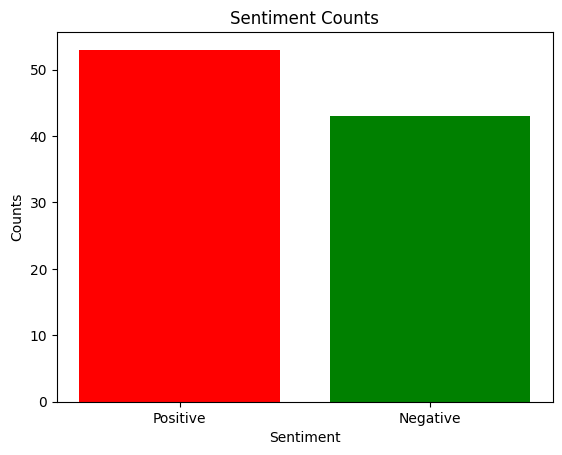

In [19]:
sentiment_counts = data['Sentiment'].value_counts()

plt.bar(sentiment_counts.index, sentiment_counts.values, color=['red', 'green'])

plt.title('Sentiment Counts')
plt.xlabel('Sentiment')
plt.ylabel('Counts')

plt.show()

In [20]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(data['Cleaned_Text'])
sequences = tokenizer.texts_to_sequences(data['Cleaned_Text'])

max_length = 100
X = pad_sequences(sequences, maxlen=max_length, padding="post")

label_encoder = LabelEncoder()
data['Sentiment'] = label_encoder.fit_transform(data['Sentiment'])
y = data['Sentiment']

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
def build_model():
    model = Sequential([
        Embedding(input_dim=10000, output_dim=64, input_length=max_length),
        LSTM(128, return_sequences=True),
        Dropout(0.5),
        LSTM(64),
        Dense(32, activation="relu"),
        Dense(len(label_encoder.classes_), activation="softmax")  # Multi-class classification
    ])

    return model

In [ ]:
model = build_model()
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 390ms/step - accuracy: 0.4980 - loss: 0.6927 - val_accuracy: 0.8000 - val_loss: 0.6704
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5116 - loss: 0.6929 - val_accuracy: 0.8000 - val_loss: 0.6631
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4882 - loss: 0.6979 - val_accuracy: 0.8000 - val_loss: 0.6785
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.5077 - loss: 0.6932 - val_accuracy: 0.8000 - val_loss: 0.6659
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5390 - loss: 0.6905 - val_accuracy: 0.8000 - val_loss: 0.6477
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.4765 - loss: 0.7011 - val_accuracy: 0.8000 - val_loss: 0.6570
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5390 - loss: 0.6900 - val_accuracy: 0.8000 - val_loss: 0.6545
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5312 - loss: 0.6908 - val_accuracy: 0.8000 - val_loss: 0.65

In [22]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Test Accuracy: {accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8000 - loss: 0.6633
Test Accuracy: 0.8000


In [4]:
save_model_path = '/content/drive/MyDrive/DeepLearning/Colab/Customer_sentiment_Classifications/model.h5'
model.save(save_model_path)

#### Load and test model

In [ ]:
# Example prediction
new_texts = ["I really love this product!", "The service is perfect!"]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded = pad_sequences(new_sequences, maxlen=max_length, padding="post")

predictions = model.predict(new_padded)
predicted_labels = np.argmax(predictions, axis=1)

# Convert numerical predictions back to sentiment labels
predicted_sentiments = label_encoder.inverse_transform(predicted_labels)
print(predicted_sentiments)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
['Positive' 'Positive']


In [83]:
load_model_path = '/content/drive/MyDrive/DeepLearning/Colab/Customer_sentiment_Classifications/model.h5'
model = load_model(load_model_path)

In [78]:
test_data = pd.read_csv('/content/drive/MyDrive/DeepLearning/Colab/Customer_sentiment_Classifications/sentiment-analysis.csv')

test_data[['Text', 'Sentiment', 'Source', 'Date/Time', 'User ID', 'Location', 'Confidence Score']] = test_data['Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score'].str.split(',', expand = True)

test_data = test_data.drop('Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score', axis=1)

In [79]:
test_data['Cleaned_Text'] = clean_text(test_data['Text'])
test_data['Sentiment'] = test_data['Sentiment'].str.strip()

test_data = test_data.dropna()

In [88]:
X_test_user = test_data['Text']
new_sequences = tokenizer.texts_to_sequences(X_test_user)
X_test_user = pad_sequences(new_sequences, maxlen=max_length, padding="post")

y_test_user = test_data["Sentiment"]
y_pred_user = model.predict(X_test_user)

y_pred_labels = np.argmax(y_pred_user, axis=1)

y_test_user_encoded = label_encoder.transform(y_test_user)

accuracy_user = accuracy_score(y_test_user_encoded, y_pred_labels)
report_user = classification_report(y_test_user_encoded, y_pred_labels)

print(f"User Test Accuracy: {accuracy_user:.2f}")
print("User Test Classification Report:\n", report_user)

num_samples = 10
sample_df = test_data.copy()
sample_df["Predicted Sentiment"] = label_encoder.inverse_transform(y_pred_labels)
print("\nSample Predictions:")
print(sample_df.head(num_samples))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
User Test Accuracy: 0.55
User Test Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.55      1.00      0.71        53

    accuracy                           0.55        96
   macro avg       0.28      0.50      0.36        96
weighted avg       0.30      0.55      0.39        96


Sample Predictions:
                                                Text Sentiment  \
0                             "I love this product!"  Positive   
1                        "The service was terrible."  Negative   
2                           "This movie is amazing!"  Positive   
3  "I'm so disappointed with their customer suppo...  Negative   
4               "Just had the best meal of my life!"  Positive   
5           "The quality of this product is subpar."  Negative   
6  "I can't stop listening to this song. It's inc...  Positive   
7      "Their website is so

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Storage

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

In [28]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5610 - loss: 0.6882
Test Accuracy: 0.5517


In [34]:
def predict_sentiment(text_list):
    text_lengths = np.array([len(text.split()) for text in text_list]).reshape(-1, 1)

    outputs = model.predict(text_lengths)
    probs = softmax(outputs, axis=-1).numpy()

    predictions = np.argmax(probs, axis=-1)

    return predictions, probs.max(axis=1)

test_data['Predicted_Sentiment'], test_data['Confidence'] = predict_sentiment(test_data['Cleaned_Text'].tolist())

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [73]:
def evaluate_model(model, test_data, tokenizer, max_length):
    if 'Cleaned_Text' not in test_data or 'Sentiment' not in test_data:
        raise ValueError("Test data must contain 'Cleaned_Text' and 'Sentiment' columns.")

    new_sequences = tokenizer.texts_to_sequences(test_data['Cleaned_Text'].astype(str).tolist())
    X_test = pad_sequences(new_sequences, maxlen=max_length, padding="post")
    y_true = test_data['Sentiment'].astype(int)

    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_true, y_pred_labels)

    report = classification_report(y_true, y_pred_labels, output_dict=True, zero_division=0)

    return {"accuracy": accuracy, "classification_report": report}

In [74]:
eval = evaluate_model(model, test_data, tokenizer, max_length) # Pass tokenizer and max_length
print("Accuracy:", eval["accuracy"])
print("Classification Report:", eval["classification_report"])

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Accuracy: 0.5520833333333334
Classification Report: {'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 43.0}, '1': {'precision': 0.5520833333333334, 'recall': 1.0, 'f1-score': 0.7114093959731543, 'support': 53.0}, 'accuracy': 0.5520833333333334, 'macro avg': {'precision': 0.2760416666666667, 'recall': 0.5, 'f1-score': 0.35570469798657717, 'support': 96.0}, 'weighted avg': {'precision': 0.3047960069444445, 'recall': 0.5520833333333334, 'f1-score': 0.3927572706935123, 'support': 96.0}}
